# User Engagement analysis

## Imports

In [1]:
import pickle
import numpy as np
import pandas as pd
from math import floor
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import zscore
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option("expand_frame_repr", False)
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from df_outlier import DfOutlier
from vis_seaborn import *
from vis_plotly import *

2021-07-19 08:59:20,289 — DfOutlier — DEBUG — Loaded successfully!


## Data reading

In [4]:
df = pd.read_csv("../data/clean_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146882 entries, 0 to 146881
Data columns (total 54 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   bearer_id                       146882 non-null  int64  
 1   start                           146882 non-null  object 
 2   start_ms                        146882 non-null  float64
 3   end                             146882 non-null  object 
 4   end_ms                          146882 non-null  float64
 5   dur_(ms)                        146882 non-null  float64
 6   imsi                            146882 non-null  int64  
 7   msisdn_number                   146882 non-null  int64  
 8   imei                            146882 non-null  int64  
 9   last_location_name              146882 non-null  object 
 10  avg_rtt_dl_(ms)                 146882 non-null  float64
 11  avg_rtt_ul_(ms)                 146882 non-null  float64
 12  avg_bearer_tp_dl

## Task 2

### Aggregate the above metrics per customer id (MSISDN) and report the top 10 customers per engagement metric


In [5]:
user_engagement_df = df[['msisdn_number', 'bearer_id', 'dur_(ms)', 'total_data']].copy(
).rename(columns={'dur_(ms)': 'duration', 'total_data': 'total_data_volume'})

We start with summing total_data_volume and duration columns by the msisdn_number. For bearer_id we count to get number of seasions by each user.

In [6]:
user_engagement = user_engagement_df.groupby(
    'msisdn_number').agg({'bearer_id': 'count', 'duration': 'sum', 'total_data_volume': 'sum'})
user_engagement = user_engagement.rename(
    columns={'bearer_id': 'sessions'})
user_engagement.head(5)

,sessions,duration,total_data_volume
msisdn_number,,,
33601001722,1,116720.00,878690574.00
33601001754,1,181230.00,156859643.00
33601002511,1,134969.00,595966483.00
33601007832,1,49878.00,422320698.00
33601008617,2,37104.00,1457410944.00


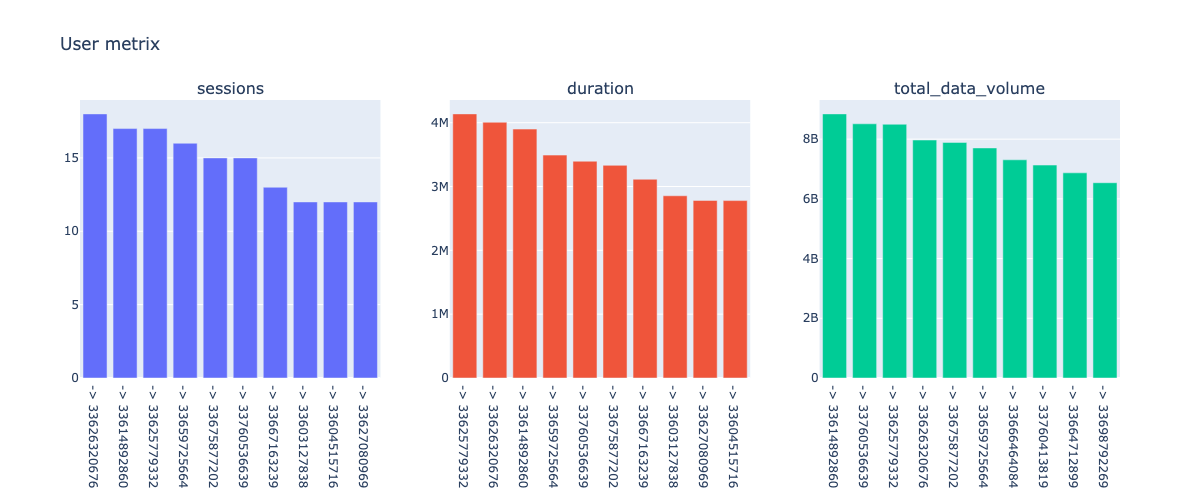

In [7]:
sessions = user_engagement.nlargest(10, "sessions")['sessions']
duration = user_engagement.nlargest(10, "duration")['duration']
total_data_volume = user_engagement.nlargest(
    10, "total_data_volume")['total_data_volume']

mult_hist([sessions, duration, total_data_volume], 1,
          3, "User metrix", ['sessions', 'duration', 'total_data_volume'])

Normalize each engagement metric and run a k-means (k=3) to classify customers in three groups of engagement

Check for outliers

<AxesSubplot:>

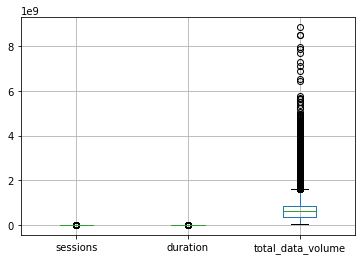

In [8]:
user_engagement.boxplot()

In [9]:
df_outliers = DfOutlier(user_engagement)
df_outliers.getOverview()

,Q1,median,Q3,IQR,skew,number_of_outliers,percentage_of_outliers,min_value,max_value,mean
label,,,,,,,,,,
sessions,1.00,1.00,2.00,1.00,3.32,3144,2.97%,1.00,18.00,1.39
duration,72723.50,103107.00,172799.00,100075.50,5.49,6877,6.51%,7142.00,4137804.00,139190.15
total_data_volume,357909940.50,616921019.00,856440351.75,498530411.25,2.23,5149,4.87%,33249009.00,8846226494.00,688846596.79


As we can see there are outlier in all columns but the data is not skewed that much.

In [10]:
df_outliers.replace_outliers_with_iqr(
    ['sessions', 'duration', 'total_data_volume'])
df_outliers = DfOutlier(user_engagement)
df_outliers.getOverview()

,Q1,median,Q3,IQR,skew,number_of_outliers,percentage_of_outliers,min_value,max_value,mean
label,,,,,,,,,,
sessions,1.00,1.00,2.00,1.00,1.80,0,0.0%,1.00,3.50,1.36
duration,72723.50,103107.00,172799.00,100075.50,0.81,0,0.0%,7142.00,322912.25,129077.22
total_data_volume,357909940.50,616921019.00,856440351.75,498530411.25,0.76,0,0.0%,33249009.00,1604235968.62,662261237.27


<AxesSubplot:>

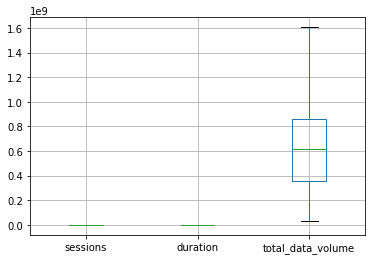

In [11]:
user_engagement.boxplot()

Normalize the engagement metric

In [12]:
scaler = StandardScaler()
scaled_array = scaler.fit_transform(user_engagement)
pd.DataFrame(scaled_array).head(5)

,0,1,2
0,-0.55,-0.15,0.55
1,-0.55,0.61,-1.28
2,-0.55,0.07,-0.17
3,-0.55,-0.93,-0.61
4,0.99,-1.08,2.01


In [13]:
data_normalized = normalize(scaled_array)
pd.DataFrame(data_normalized).head(5)

,0,1,2
0,-0.70,-0.18,0.69
1,-0.36,0.40,-0.84
2,-0.95,0.12,-0.29
3,-0.44,-0.75,-0.49
4,0.40,-0.43,0.81


In [14]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(data_normalized)
kmeans.labels_

array([2, 1, 1, ..., 2, 1, 1], dtype=int32)

In [15]:
user_engagement.insert(0, 'cluster', kmeans.labels_)
user_engagement.head(5)

,cluster,sessions,duration,total_data_volume
msisdn_number,,,,
33601001722,2,1.00,116720.00,878690574.00
33601001754,1,1.00,181230.00,156859643.00
33601002511,1,1.00,134969.00,595966483.00
33601007832,2,1.00,49878.00,422320698.00
33601008617,0,2.00,37104.00,1457410944.00


In [16]:
user_engagement['cluster'].value_counts()

2    52844
0    28333
1    24537
Name: cluster, dtype: int64

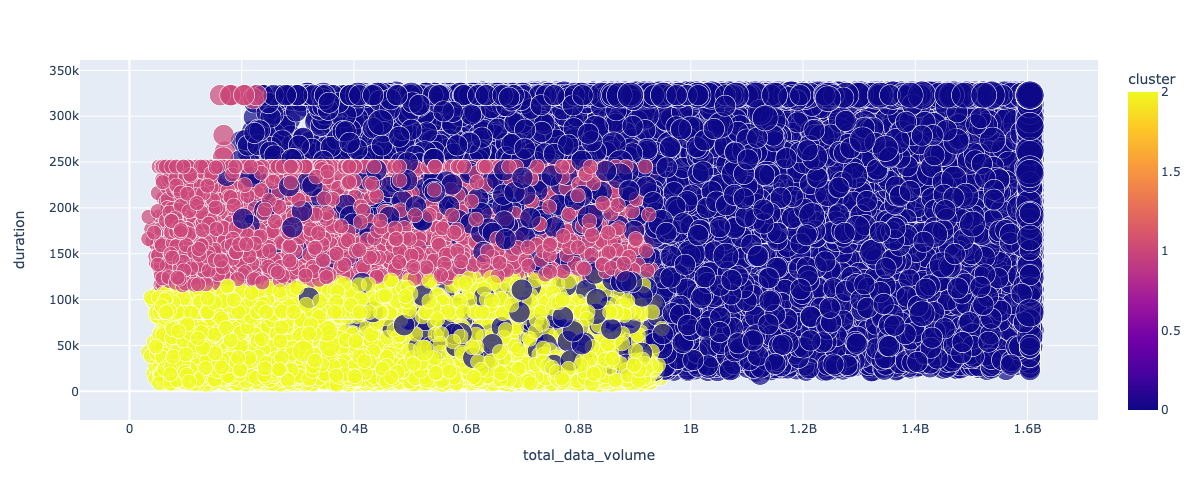

In [17]:
fig = px.scatter(user_engagement, x='total_data_volume', y="duration",
                 color='cluster', size='sessions')
# fig.show()
Image(pio.to_image(fig, format='png', width=1200))

Here we can see the clusters but for clarity lets draw theme in 3D space

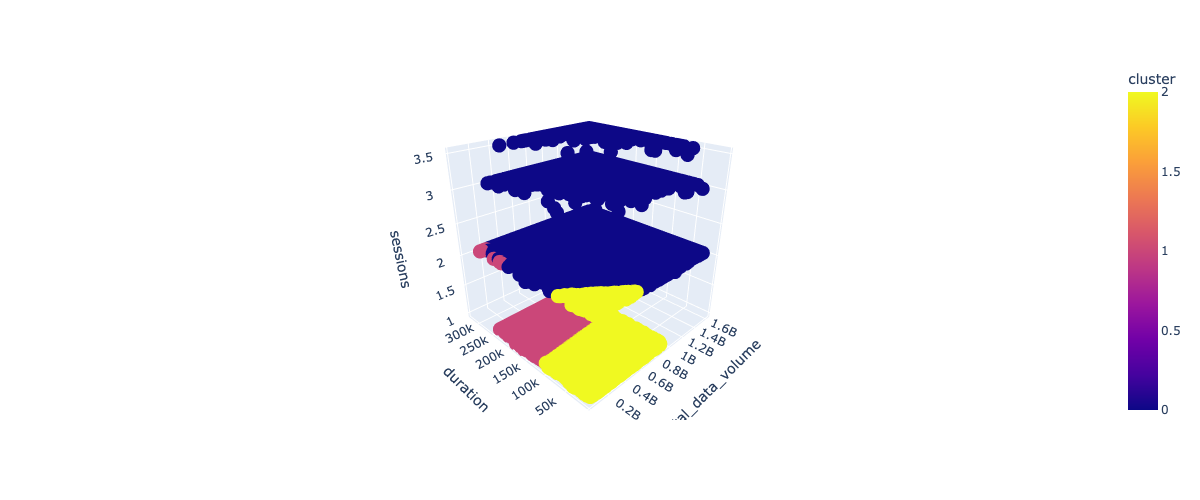

In [18]:
scatter3D(user_engagement, x="total_data_volume", y="duration", z="sessions",
          c="cluster", rotation=[-1.5, -1.5, 1])

Compute the minimum, maximum, average & total non-normalized metrics for each cluster. Interpret your results visually with accompanying text explaining your findings.

In [19]:
cluster1 = user_engagement[user_engagement["cluster"]==0]
cluster1.describe()

,cluster,sessions,duration,total_data_volume
count,28333.00,28333.00,28333.00,28333.00
mean,0.00,2.32,207823.46,1114860723.81
std,0.00,0.55,93300.47,372816245.06
min,0.00,2.00,18235.00,119768539.00
25%,0.00,2.00,131455.00,834102632.00
50%,0.00,2.00,200149.00,1115265224.00
75%,0.00,3.00,317884.00,1466216819.00
max,0.00,3.50,322912.25,1604235968.62


In [20]:
cluster2 = user_engagement[user_engagement["cluster"] == 1]
cluster2.describe()

,cluster,sessions,duration,total_data_volume
count,24537.00,24537.00,24537.00,24537.00
mean,1.00,1.00,172001.32,488803995.50
std,0.00,0.02,38834.84,245161031.52
min,1.00,1.00,115401.00,33575840.00
25%,1.00,1.00,141023.00,276908834.00
50%,1.00,1.00,162491.00,485300592.00
75%,1.00,1.00,190957.00,700935947.00
max,1.00,2.00,322912.25,950760661.00


In [21]:
cluster3 = user_engagement[user_engagement["cluster"] == 1]
cluster3.describe()

,cluster,sessions,duration,total_data_volume
count,24537.00,24537.00,24537.00,24537.00
mean,1.00,1.00,172001.32,488803995.50
std,0.00,0.02,38834.84,245161031.52
min,1.00,1.00,115401.00,33575840.00
25%,1.00,1.00,141023.00,276908834.00
50%,1.00,1.00,162491.00,485300592.00
75%,1.00,1.00,190957.00,700935947.00
max,1.00,2.00,322912.25,950760661.00


Aggregate user total traffic per application and derive the top 10 most engaged users per application

In [22]:
app_df = df.groupby(
    'msisdn_number').agg({'gaming': 'sum', 'youtube': 'sum', 'netflix': 'sum', 'google': 'sum', 'email': 'sum', 'social_media': 'sum', 'other': 'sum'})
app_df.head()

,gaming,youtube,netflix,google,email,social_media,other
msisdn_number,,,,,,,
33601001722,812458661.00,21624548.00,27180981.00,4389005.00,1331362.00,2232135.00,386570872.00
33601001754,119750078.00,12432223.00,11221763.00,5334863.00,3307781.00,2660565.00,281710071.00
33601002511,538827713.00,21333570.00,19353900.00,3443126.00,3205380.00,3195623.00,501693672.00
33601007832,391126127.00,6977321.00,1942092.00,9678493.00,2284670.00,280294.00,35279702.00
33601008617,1314797820.00,41533002.00,49201724.00,18499616.00,3305469.00,2912542.00,804804484.00


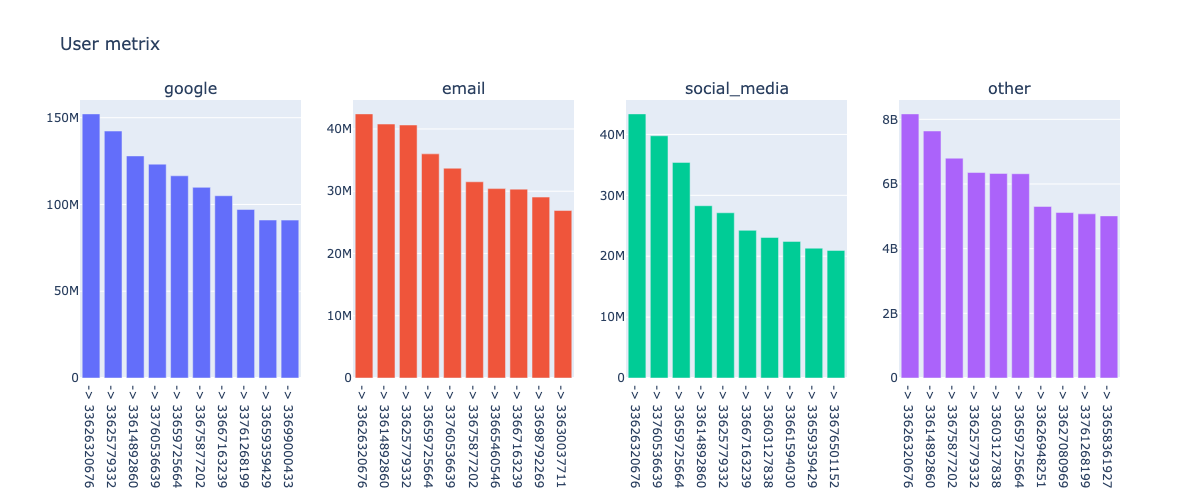

In [23]:
gaming = app_df.nlargest(10, "gaming")['gaming']
youtube = app_df.nlargest(10, "youtube")['youtube']
netflix = app_df.nlargest(10, "netflix")['netflix']
google = app_df.nlargest(10, "google")['google']
email = app_df.nlargest(10, "email")['email']
social_media = app_df.nlargest(10, "social_media")['social_media']
other = app_df.nlargest(10, "other")['other']


mult_hist([gaming, youtube, netflix], 1,
          3, "User metrix", ["gaming", "youtube", "netflix"])
mult_hist([google, email, social_media, other], 1,
          4, "User metrix", [ "google", "email", "social_media", "other"])


Plot the top 3 most used applications using appropriate charts.

In [24]:
top_3 = app_df.sum()
top_3

gaming         63210445311674.00
youtube         3325647366268.00
netflix         3323856436688.00
google          1146853928366.00
email            331814180041.00
social_media     268463430356.00
other          63050740157370.00
dtype: float64

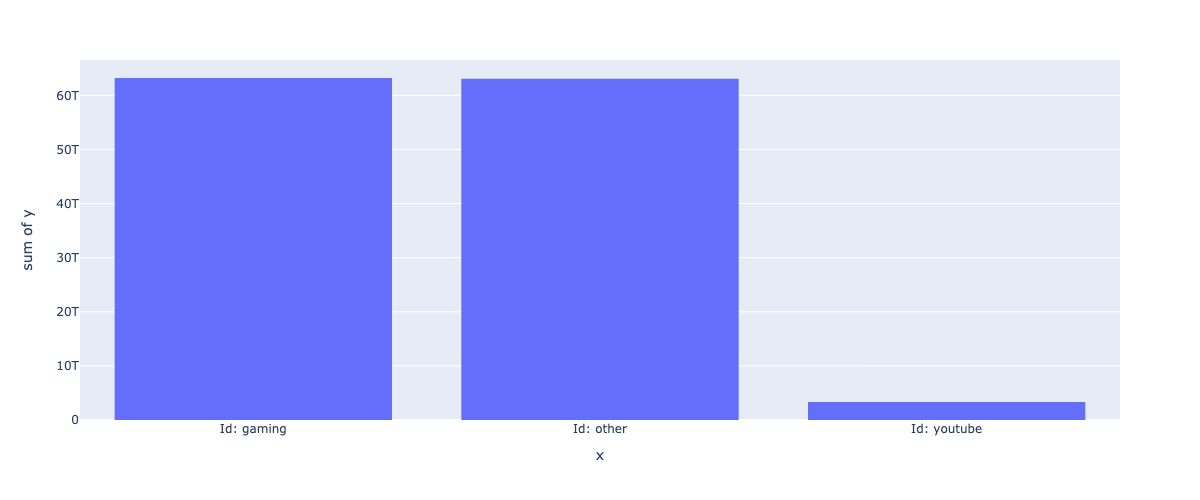

In [25]:
hist(top_3.nlargest(3))

Using k-means clustering algorithm, group users in k engagement clusters based on the engagement metrics. 
- What is the optimized value of k(use elbow method for this)?
- Interpret your findings.


`Distortion` is the average of the euclidean squared distance from the centroid of the respective clusters. 

`Inertia` is the sum of squared distances of samples to their closest cluster centre.


In [26]:
def choose_kmeans(df: pd.DataFrame, num: int):
  distortions = []
  inertias = []
  K = range(1, num)
  for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df)
    distortions.append(sum(
        np.min(cdist(df, kmeans.cluster_centers_, 'euclidean'), axis=1)) / df.shape[0])
    inertias.append(kmeans.inertia_)

  return (distortions, inertias)

In [27]:
distortions, inertias = choose_kmeans(data_normalized, 15)

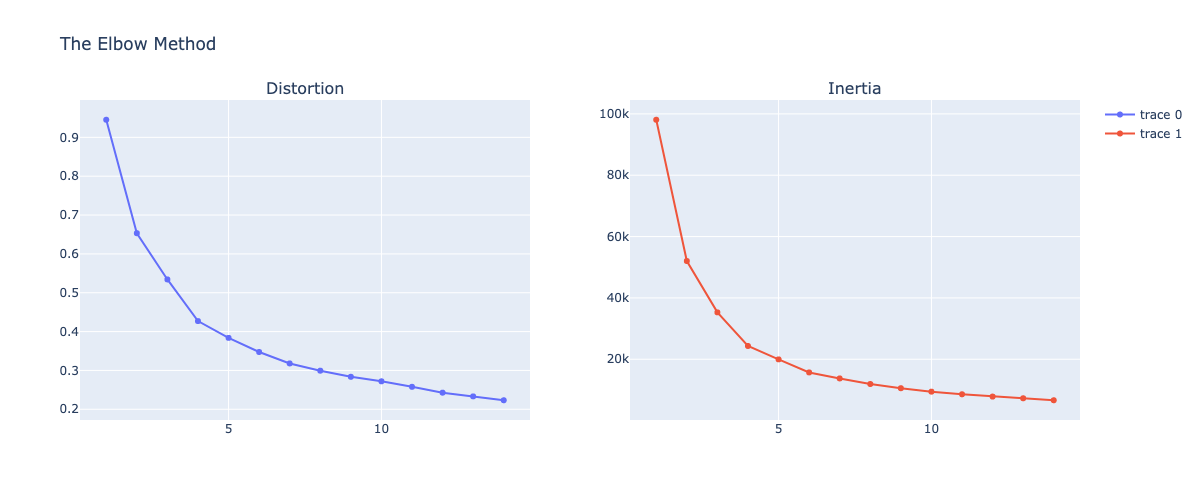

In [28]:
fig = make_subplots(
    rows=1, cols=2, subplot_titles=("Distortion", "Inertia")
)
fig.add_trace(go.Scatter(x=np.array(range(1, 15)), y=distortions), row=1, col=1)
fig.add_trace(go.Scatter(x=np.array(range(1, 15)), y=inertias), row=1, col=2)
fig.update_layout(title_text="The Elbow Method")
# fig.show(config=config)
Image(pio.to_image(fig, format='png', width=1200))

From this two plots we can see 4 clusters are the optimal value 
since there is not a significant decrease in distortion and inertia after that.

In [29]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(data_normalized)
user_engagement["cluster"]= kmeans.labels_
user_engagement


,cluster,sessions,duration,total_data_volume
msisdn_number,,,,
33601001722,3,1.00,116720.00,878690574.00
33601001754,2,1.00,181230.00,156859643.00
33601002511,2,1.00,134969.00,595966483.00
33601007832,0,1.00,49878.00,422320698.00
33601008617,1,2.00,37104.00,1457410944.00
...,...,...,...,...
33789967113,2,1.00,160461.00,208123067.00
33789980299,1,2.00,210389.00,1094693386.00
33789996170,3,1.00,8810.00,714641641.00


In [30]:
user_engagement.shape

(105714, 4)

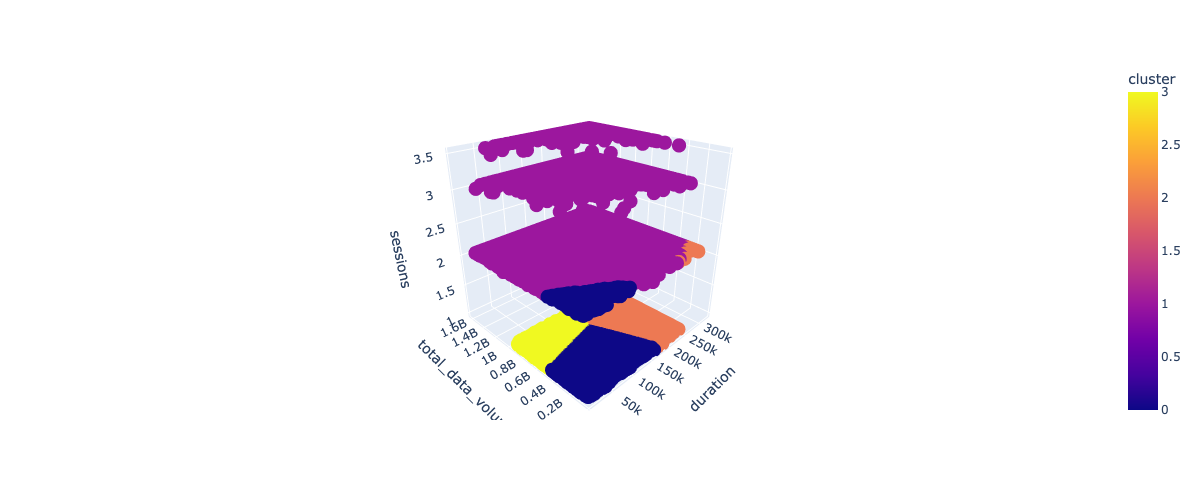

In [31]:
# scatter3D(user_engagement, x="total_data_volume", y="duration", z="sessions",
#           c="cluster", interactive=True)
scatter3D(user_engagement, y="total_data_volume", x="duration", z="sessions",
          c="cluster", rotation=[-1.5, -1.5, 1])

Save the final model

In [32]:
with open("../models/user_engagement.pkl", "wb") as f:
    pickle.dump(kmeans, f)

In [33]:
user_engagement.to_csv('../data/user_engagement.csv')